In [86]:
# importing required modules to analyse and connect google sheet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gspread

# importing required modules to collect stock details

from datetime import date
import datetime
from jugaad_data.nse import bhavcopy_save, bhavcopy_fo_save

from jugaad_data.nse import stock_df

#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [87]:
gc = gspread.service_account(filename='my-project-ml-367716-b43def299cfa.json')
Users_Sheet = gc.open("Users_Sheet")



from google.oauth2.service_account import Credentials
scopes = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]
credentials = Credentials.from_service_account_file(
    'my-project-ml-367716-b43def299cfa.json',
    scopes=scopes
)
gc = gspread.authorize(credentials)

In [88]:
# to update in google sheet

f_r = gc.open("Users_Sheet").sheet1

In [89]:
user_df = pd.DataFrame(Users_Sheet.sheet1.get('A1:D2'))

In [90]:
# converting first row to header

new_header = user_df.iloc[0]
user_df = user_df[1:]
user_df.columns = new_header

In [91]:
# collecting single data values from user input dataframe

Stock_symbol = user_df['Stock Name'].iloc[0]
print(Stock_symbol)


TCS


In [92]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=Stock_symbol,period='4y',interval='1d')


[*********************100%***********************]  1 of 1 completed


In [93]:
print(len(data))
print(data.head())
print(data.tail())

1006
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2018-11-08  6.03  6.42  6.01   6.40   5.982609  515600
2018-11-09  6.33  6.38  6.03   6.08   5.683478  403700
2018-11-12  6.02  6.22  5.98   6.14   5.739565  218800
2018-11-13  6.14  6.14  5.82   5.93   5.543261  314300
2018-11-14  6.04  6.13  5.86   5.92   5.533913  219300
            Open  High   Low  Close  Adj Close   Volume
Date                                                   
2022-11-01  5.33  5.47  4.81   5.10       5.10  1023600
2022-11-02  4.87  4.96  4.45   4.49       4.49   804700
2022-11-03  4.52  4.75  4.45   4.62       4.62   547300
2022-11-04  4.79  4.79  4.30   4.42       4.42   592800
2022-11-07  4.43  4.58  4.38   4.57       4.57   477000


In [94]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

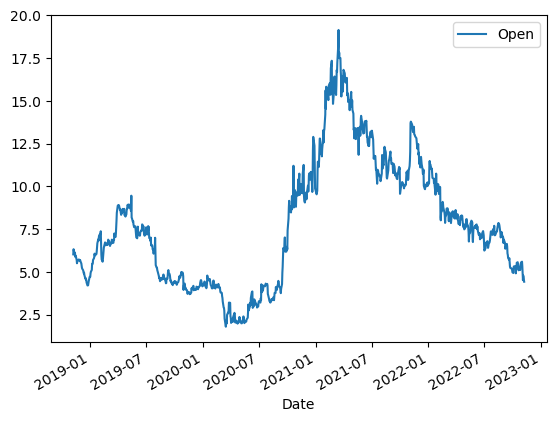

In [95]:
opn.plot()

In [96]:
ds = opn.values
ds

array([[6.03000021],
       [6.32999992],
       [6.01999998],
       ...,
       [4.51999998],
       [4.78999996],
       [4.42999983]])

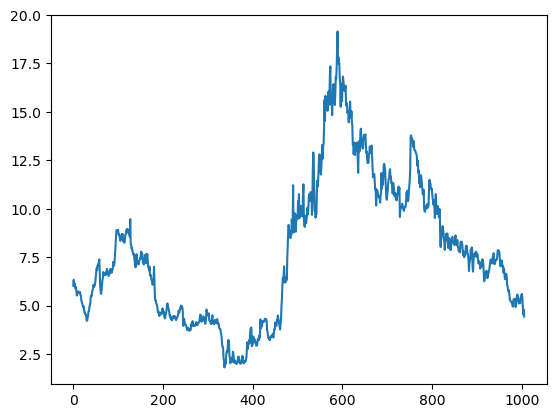

In [97]:
plt.plot(ds)

In [98]:
from sklearn.preprocessing import MinMaxScaler

In [99]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [100]:
len(ds_scaled), len(ds)

(1006, 1006)

In [101]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [102]:
train_size,test_size

(704, 302)

In [103]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [104]:
len(ds_train),len(ds_test)

(704, 302)

In [105]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [106]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [107]:
X_train.shape,y_train.shape

((603, 100), (603,))

In [108]:
X_test.shape, y_test.shape

((201, 100), (201,))

In [109]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [110]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [111]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [112]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
10/10 [==============================] - 17s 658ms/step - loss: 0.0633 - val_loss: 0.0076
Epoch 2/100
10/10 [==============================] - 4s 372ms/step - loss: 0.0112 - val_loss: 0.0029
Epoch 3/100
10/10 [==============================] - 4s 360ms/step - loss: 0.0052 - val_loss: 8.6389e-04
Epoch 4/100
10/10 [==============================] - 4s 406ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 5/100
10/10 [==============================] - 4s 396ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 6/100
10/10 [==============================] - 4s 360ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 7/100
10/10 [==============================] - 4s 364ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/100
10/10 [==============================] - 4s 360ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 9/100
10/10 [==============================] - 4s 359ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/100
10/10 [==============================] - 4s 365ms/step - loss: 0.0025 - v

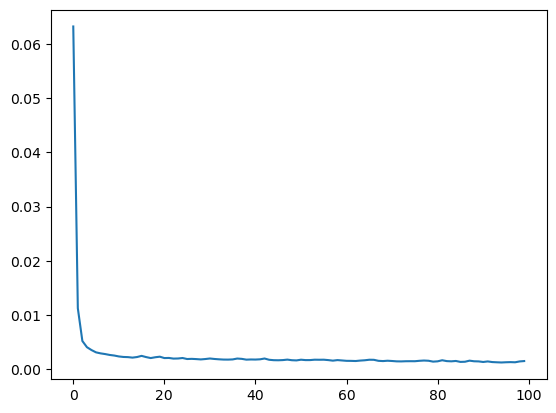

In [113]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [114]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

7/7 [==============================] - 1s 85ms/step


In [115]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

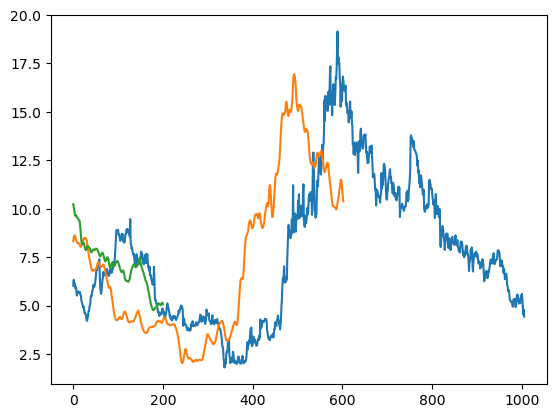

In [116]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [117]:
type(train_predict)

numpy.ndarray

In [118]:
test = np.vstack((train_predict,test_predict))

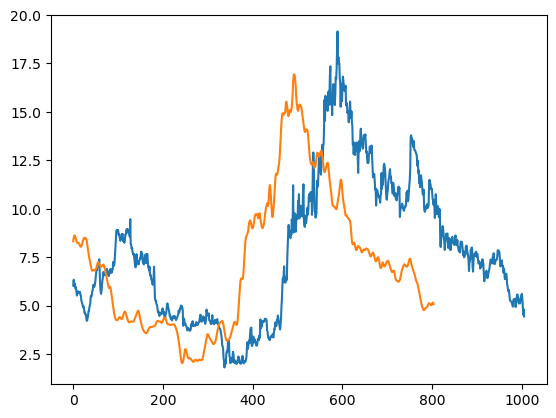

In [119]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [120]:
len(ds_test)

302

In [121]:
#Getting the last 100 days records
fut_inp = ds_test[202:]

In [122]:
fut_inp = fut_inp.reshape(1,-1)

In [123]:
tmp_inp = list(fut_inp)

In [124]:
fut_inp.shape

(1, 100)

In [125]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [81]:
data[Date]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-08,6.03,6.42,6.01,6.40,5.982609,515600
2018-11-09,6.33,6.38,6.03,6.08,5.683478,403700
2018-11-12,6.02,6.22,5.98,6.14,5.739565,218800
2018-11-13,6.14,6.14,5.82,5.93,5.543261,314300
2018-11-14,6.04,6.13,5.86,5.92,5.533913,219300
...,...,...,...,...,...,...
2022-11-01,5.33,5.47,4.81,5.10,5.100000,1023600
2022-11-02,4.87,4.96,4.45,4.49,4.490000,804700
2022-11-03,4.52,4.75,4.45,4.62,4.620000,547300


In [82]:
from datetime import datetime

# dates in string format
str_d1 = '2021-10-20'
str_d2 = '2022-02-20'

# convert string to date object
d1 = datetime.strptime(str_d1, "%Y-%m-%d")
d2 = datetime.strptime(str_d2, "%Y-%m-%d")

# difference between dates in timedelta
delta = d2 - d1
delta = str(delta)
string =''
for i in delta:
    if i.isnumeric():
        string+=i
    else:
        break

In [83]:
string

'123'

In [126]:
#Predicting next n_days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.17392593622207642], [0.1669963002204895], [0.16139550507068634], [0.1568513810634613], [0.15299277007579803], [0.14952653646469116], [0.1462666392326355], [0.14311251044273376], [0.14001762866973877], [0.13696512579917908], [0.1339520364999771], [0.1309807449579239], [0.12805505096912384], [0.12517841160297394], [0.12235378473997116], [0.11958347260951996], [0.11686933040618896], [0.11421291530132294], [0.11161553114652634], [0.10907821357250214], [0.10660190880298615], [0.10418727248907089], [0.10183484852313995], [0.09954492002725601], [0.0973176583647728], [0.09515304863452911], [0.09305085986852646], [0.09101082384586334], [0.08903250098228455], [0.08711528033018112]]


In [127]:
len(ds_scaled)

1006

In [128]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

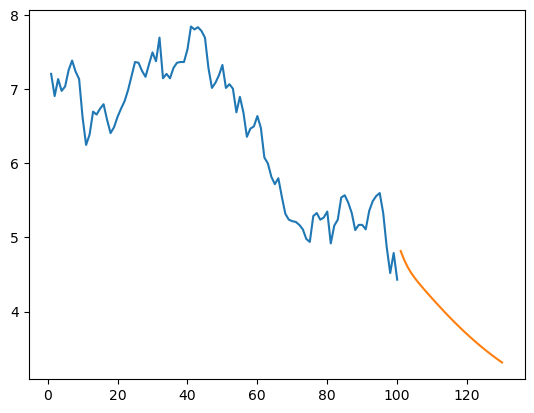

In [129]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[906:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [130]:
ds_new = ds_scaled.tolist()

In [131]:
len(ds_new)

1006

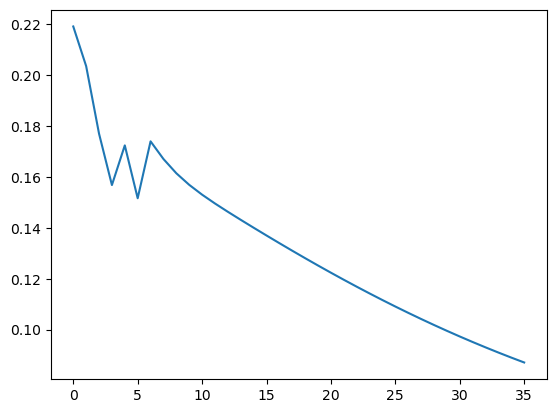

In [132]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1000:])

In [133]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

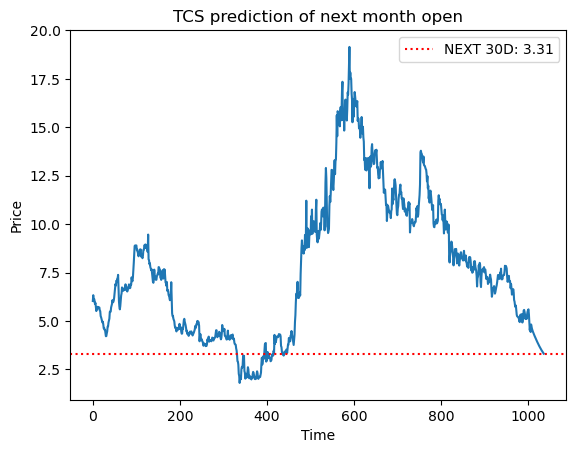

In [134]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(Stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()